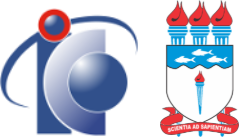

> ## **UNIVERSIDADE FEDERAL DE ALAGOAS - UFAL**
> ### **INSTITUTO DE COMPUTAÇÃO - IC**
> #### Nome: **José Arthur Lopes Sabino**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **|**&emsp; Mat.: **20211839**&emsp;**|**&emsp;C.: **Ciência da Computação**
> #### Nome: **Karla Sophia Santana da Cruz**&emsp;&nbsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **|**&emsp; Mat.: **19111113**&emsp;**|**&emsp;C.: **Engenharia de Computação**
> #### Nome: **Letícia Gabriela Cena de Lima**&emsp;&nbsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **|**&emsp; Mat.: **18113063**&emsp;**|**&emsp;C.: **Engenharia de Computação**
> #### Nome: **Maria Fernanda Herculano Machado de Silva**&emsp;&nbsp;&nbsp; **|**&emsp; Mat.: **19111118**&emsp;**|**&emsp;C.: **Engenharia de Computação**
> #### Período: **2023.1**

> # **Otimização Bioinspirada - Erick Barbosa**
> # **Laboratório 1 - Projeto PSO**

> ## **IMPLEMENTAÇÃO**

#### requirements

In [ ]:
from __future__ import division
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
plt.style.use('ggplot')

### Funções de Custo

In [ ]:
def sphere(x):
    total = 0

    for i in range(len(x)):
        total += x[i]**2

    return total

def ackley(x):
    total = sum1 = sum2 = 0
    n = len(x)

    for i in range(n):
        sum1 += x[i] ** 2
        sum2 += math.cos(2 * math.pi * x[i])

    total = -20.0 * math.exp(-0.2 * math.sqrt(1/n * sum1)) - math.exp(1/n * sum2) + math.e + 20.0

    return total

def rastrigin(x):
    total = 10 * len(x)

    for i in range(len(x)):
        total += x[i]**2 - (10 * math.cos(2 * math.pi * x[i]))

    return total

### Varíaveis pré-definidas

In [ ]:
max_iter = 100 # número de iteração máximo
num_particles = 50 # número de partículas

# Limites de cada Função de Custo
# ackley_bounds =    [(-32.768, 32.768)] * 4
sphere_bounds =    [(-5.12, 5.12)] * 4
rastrigin_bounds = [(-5.12, 5.12)] * 4
ackley_bounds =    [(-5.12, 5.12)] * 4

### Funções Auxiliares

In [ ]:
# -------------------------------- Atividades 1 e 2 --------------------------------

# Função para plotar os gráficos de boxplots
def plot_graphics(data_ex, titles, xtick_labels, xlabel, suptitle):
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    fig.supxlabel(xlabel, fontsize=12)
    fig.supylabel('Variação do Melhor Fitness\n', fontsize=12)
    fig.suptitle(suptitle, fontsize=18)

    max_value = max(np.max(data) for data in data_ex)

    for i, data in enumerate(data_ex):
        axs[i].boxplot(data)
        axs[i].set_title(titles[i], fontsize=14)
        axs[i].set_xticklabels(xtick_labels)
        axs[i].set_ylim(-0.9, max_value + 0.5)

    plt.tight_layout()
    plt.show()

# -------------------------------- Atividades 3 e 4 --------------------------------

# Função que retorna a mediana, o mínimo e o máximo por iteração total (30 execuções)
def median_min_max_by_exec(results):
  median_min_max = []

  for const in range(2):
    results_iter = zip(*results[const])
    results_median = []
    results_min_max = []

    for iter in results_iter:
      results_median.append(np.median(iter))
      results_min_max.append([min(iter), max(iter)])

    median_min_max.append([results_median, results_min_max])

  return median_min_max

# Função para plotar os gráficos de barra de erro
def plot_graphic_2(results, titles, suptitle, xlabel, legend, num_exec = 30):
    fig, axs = plt.subplots(1, 3, figsize = (16, 6))
    fig.supxlabel(xlabel, fontsize=12)
    fig.supylabel('Variação do Melhor Fitness\n', fontsize=12)
    fig.suptitle(suptitle, fontsize=18)

    colors = ["navy", "lightskyblue"]
    global_max = -float('inf')

    for i in range(3):
        for j in range(2):
            medians = results[i][j][0]
            min_max = results[i][j][1]

            medians = medians[9 : : 10]
            min_max = min_max[9 : : 10]

            x = [i * 10 for i in range(1, len(medians) + 1)]

            error_min = [medians[k] - min_max[k][0] for k in range(len(medians))]
            error_max = [min_max[k][1] - medians[k] for k in range(len(medians))]

            axs[i].plot(x, medians, marker = 'o', linestyle = '-', label = legend[j], color = colors[j])
            axs[i].errorbar(x, medians, yerr = [error_min, error_max], fmt = 'o', capsize = 4, color = colors[j])

            local_max = max(max(min_max))
            if local_max > global_max:
                global_max = local_max

    for i in range(3):
        axs[i].set_title(titles[i])
        axs[i].grid(True)
        axs[i].set_ylim(-0.9, global_max + 0.5)

    plt.tight_layout()
    plt.legend(loc = 'upper center', bbox_to_anchor = (-0.7, 1.2), ncol = 2)
    plt.show()

### PSO

In [ ]:
class Particle:
    def __init__(self, bounds, num_dimensions, const_factor):
        self.position_i = []              # posição
        self.velocity_i = []              # velocidade
        self.fitness_i = -1               # fitness
        self.pos_best_i = []              # melhor posição
        self.fitness_best_i = -1          # melhor fitness
        self.num_dimensions = num_dimensions # número de dimensões
        self.const_factor = const_factor # Falso -> Tradicional, True -> com Fator de Constrição

        # Inicializa a partícula em posições e velocidades aleatórias
        for i in range(self.num_dimensions):
            self.velocity_i.append(random.uniform(-1, 1))
            self.position_i.append(random.uniform(bounds[i][0], bounds[i][1]))

    # Função que avalia a partícula de acordo com a Função de Custo
    def evaluate(self, costFunc):
        self.fitness_i = costFunc(self.position_i)

        # Checa se a posição atual é a melhor posição
        if self.fitness_i < self.fitness_best_i or self.fitness_best_i == -1:
            self.pos_best_i = self.position_i
            self.fitness_best_i = self.fitness_i

    # Função que atualiza a velocidade da partícula utlizando a melhor posição
    def update_velocity(self, pos_best_g, w):
        c1 = 2.1        # constante cognitiva
        c2 = 2.1        # constante social

        # se for usado o Fator de Constrição (k), o Peso de Inércia é ignorado
        w = 1 if self.const_factor else w
        k = 0.6417 if self.const_factor else 1 # Fator de Constrição pré-calculado

        for i in range(self.num_dimensions):
            r1 = random.random()
            r2 = random.random()

            vel_cognitive = c1 * r1 * (self.pos_best_i[i] - self.position_i[i])

            vel_social = c2 * r2 * (pos_best_g[i] - self.position_i[i])

            self.velocity_i[i] = k * (w * self.velocity_i[i] + vel_cognitive + vel_social)

    # Função que atualiza a posição baseada na velocidade atualizada
    def update_position(self, bounds):
        for i in range(self.num_dimensions):
            self.position_i[i] = self.position_i[i] + self.velocity_i[i]

            # ajusta a posição caso ultrapasse o limite máximo
            if self.position_i[i] > bounds[i][1]:
                self.position_i[i] = bounds[i][1]

            # ajusta a posição caso ultrapasse o limite mínimo
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i] = bounds[i][0]

class PSO():
    def __init__(self, costFunc, bounds, num_particles = 50, maxiter = 100, w = 0.5, num_dimensions = 3, const_factor = False, local_topology = False):
        self.results = []   # melhores fitness por iteração

        fitness_best_g = -1               # melhor fitness da iteração
        pos_best_g = []                   # melhor posição da iteração
        swarm = []                        # enxame de partículas

        # inicializa as partículas
        for i in range(num_particles):
            swarm.append(Particle(bounds, num_dimensions, const_factor))

        # inicializa a otimização até o limite máximo de iterações
        i = 0
        while i < maxiter:
            # avalia as partículas do enxame
            for j in range(num_particles):
                swarm[j].evaluate(costFunc)

            # checa se a atualização da velocidade é com Topologia Local
            if local_topology:
                for j in range(num_particles):
                    # determina os vizinhos da partícula atual
                    neighbors = self.get_neighbors(swarm, j, num_particles)

                    # encontra o melhor fitness entre os vizinhos
                    local_best_g = self.find_local_best(swarm, neighbors)

                    # checa se o melhor fitness atual é o melhor fitness da iteração
                    if local_best_g is not None and (costFunc(local_best_g) < fitness_best_g or fitness_best_g == -1):
                        pos_best_g = list(local_best_g)
                        fitness_best_g = float(costFunc(local_best_g))

                    # atualiza a velocidade da partícula
                    swarm[j].update_velocity(local_best_g, w)
            else:
                # atualiza a velocidade com a Topologia Global
                for j in range(num_particles):
                    #  checa se o melhor fitness atual é o melhor fitness da iteração
                    if swarm[j].fitness_i < fitness_best_g or fitness_best_g == -1:
                        pos_best_g = list(swarm[j].position_i)
                        fitness_best_g = float(swarm[j].fitness_i)

                # atualiza a velocidade das partículas
                for j in range(num_particles):
                    swarm[j].update_velocity(pos_best_g, w)

            # atualiza a posição das partículas
            for j in range(num_particles):
              swarm[j].update_position(bounds)

            i += 1

            # insere o melhor fitness da iteração nos resultados
            self.results.append(fitness_best_g)

    # Função que calcula os dois vizinhos mais próximos de uma partícula
    def get_neighbors(self, swarm, current_particle_index, num_particles):
        neighbors = [float('inf'), float('inf')]
        closest_distances = [float('inf'), float('inf')]

        current_particle = swarm[current_particle_index]

        for j in range(0, num_particles):
            if j == current_particle_index:
                continue

            neighbor = swarm[j]

            # cálculo do vizinho com distância euclidiana
            distance = math.dist(current_particle.position_i, neighbor.position_i)

            if distance < closest_distances[0]:
                closest_distances[1] = closest_distances[0]
                closest_distances[0] = distance
                neighbors[1] = neighbors[0]
                neighbors[0] = j

            elif distance < closest_distances[1]:
                closest_distances[1] = distance
                neighbors[1] = j

        return neighbors

    # Função que retorna o melhor fitness entre os vizinhos
    def find_local_best(self, swarm, neighbors):
        local_best_fitness = float('inf')
        local_best_position = None

        for neighbor_index in neighbors:
            neighbor = swarm[neighbor_index]
            if neighbor.fitness_i < local_best_fitness:
                local_best_fitness = neighbor.fitness_i
                local_best_position = neighbor.position_i

        return local_best_position

### Teste Estatístico

In [ ]:
def perform_statistical_tests(data, parameter_values, parameter_name):
    num_values = len(parameter_values)
    alpha = 0.05  # Nível de significância

    results = []

    for i in range(num_values):
        value1 = parameter_values[i]
        data1 = data[i]
        label1 = f"{parameter_name}: {value1}"

        for j in range(i + 1, num_values):
            value2 = parameter_values[j]
            data2 = data[j]
            label2 = f"{parameter_name}: {value2}"

            result = {}

            # Teste de normalidade (Shapiro-Wilk)
            _, p_value1 = stats.shapiro(data1)
            _, p_value2 = stats.shapiro(data2)

            result['Label 1'] = label1
            result['Label 2'] = label2

            # Escolher o teste com base nos resultados dos testes de normalidade
            if p_value1 > alpha and p_value2 > alpha: # distribuição normal --> t-test
                t_statistic, p_ttest = stats.ttest_ind(data1, data2)
                test_type = "t-test"
                result['Tipo de Teste'] = test_type
                result['p-value t-test'] = p_ttest
            else:
                # não segue uma distribuição normal --> Wilcoxon test
                _, p_value = stats.ranksums(data1, data2)
                test_type = "Wilcoxon test"
                result['Tipo de Teste'] = test_type
                if (type(p_value) == np.ndarray):
                  p_wilcoxon = np.min(p_value)
                else:
                  p_wilcoxon = p_value
                result['p-value Wilcoxon'] = p_wilcoxon

            # Interpretar os resultados
            if p_value1 > alpha and p_value2 > alpha:
                if p_ttest < alpha:
                    result['Resultado'] = 'Diferença significativa (t-test)'
                else:
                    result['Resultado'] = 'Sem diferença significativa (t-test)'
            else:
                if p_wilcoxon < alpha :
                    result['Resultado'] = 'Diferença significativa (Wilcoxon test)'
                else:
                    result['Resultado'] = 'Sem diferença significativa (Wilcoxon test)'

            results.append(result)

    results_df = pd.DataFrame(results)

    return results_df

> ## **ATIVIDADE**

### **1.** Variar o tamanho do enxame no intervalo [30 - 100] em passos de 10

In [ ]:
particles_range = list(range(30, 101, 10))

sphere_ex = []
rastrigin_ex = []
ackley_ex = []

for num_particle in particles_range:
  sphere_part = []
  rastrigin_part = []
  ackley_part = []

  for i in range(30):
      sphere_pso = PSO(sphere, sphere_bounds, num_particles=num_particle, maxiter=max_iter)
      sphere_part.append(min(sphere_pso.results))

      rastrigin_pso = PSO(rastrigin, rastrigin_bounds, num_particles=num_particle, maxiter=max_iter)
      rastrigin_part.append(min(rastrigin_pso.results))

      ackley_pso = PSO(ackley, ackley_bounds, num_particles=num_particle, maxiter=max_iter)
      ackley_part.append(min(ackley_pso.results))

  sphere_ex.append(sphere_part)
  rastrigin_ex.append(rastrigin_part)
  ackley_ex.append(ackley_part)

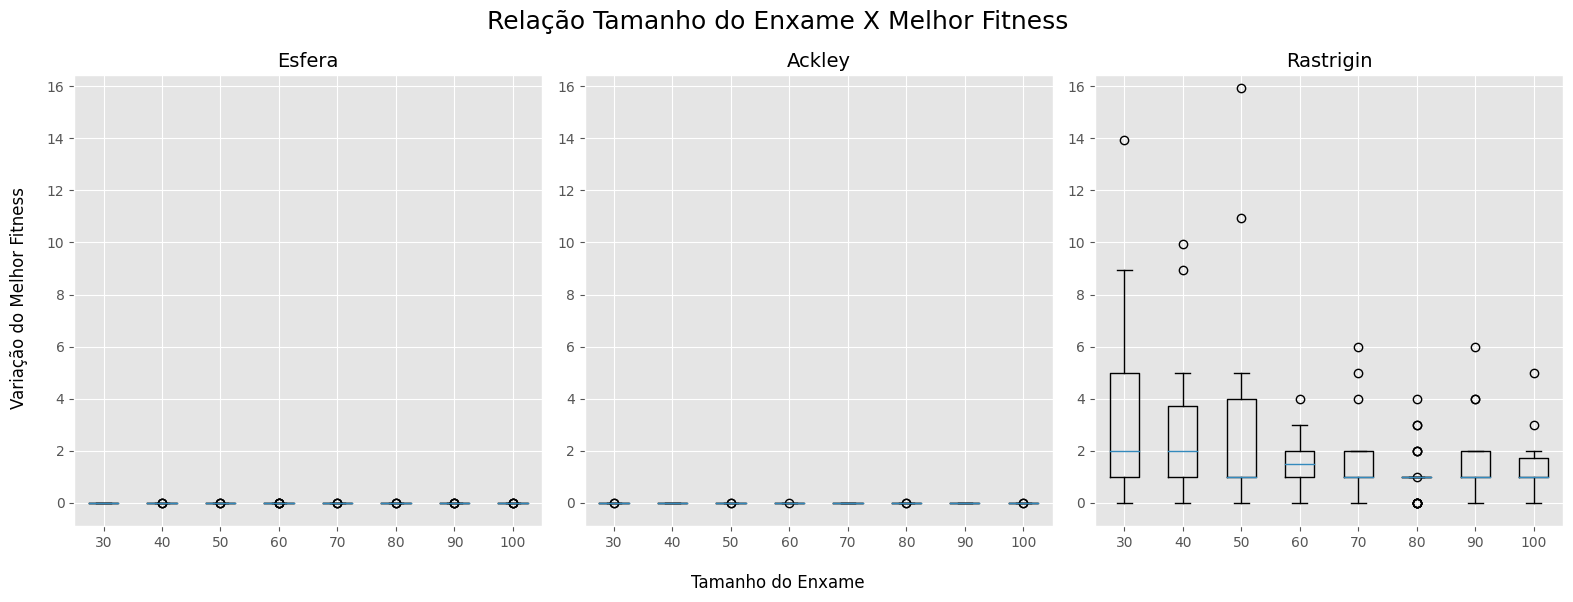

In [ ]:
data_1 = [sphere_ex, ackley_ex, rastrigin_ex]
titles = ["Esfera", "Ackley", "Rastrigin"]
suptitle = 'Relação Tamanho do Enxame X Melhor Fitness'
xlabel = 'Tamanho do Enxame'
plot_graphics(data_1, titles, particles_range, xlabel, suptitle)

#### Nas funções de Esfera e Ackley, alterar o tamanho do enxame não teve mudanças significativas, visto que elas são funções menos complexas de convergir.

#### No entanto, para a função Rastrigin, alterar o tamanho do enxame influenciou relativamente na convergência. Porém, pode-se analisar que o melhor fitness é estabilizado a partir de 40 partículas, mesmo ocorrendo variações no espaço de execuções que mostre que tamanhos maiores ocasionaram em uma convergência melhor (distribuição dos melhores fitness mais próximos a 0).

### **2.** Variar o valor de inércia no intervalo [0,1 - 0,9] em passos de 0,1

In [ ]:
inertia_range = np.arange(0.1, 1, 0.1)

sphere_ex2 = []
rastrigin_ex2 = []
ackley_ex2 = []

for w in inertia_range:
  sphere_part = []
  rastrigin_part = []
  ackley_part = []

  for i in range(30):
      sphere_pso = PSO(sphere, sphere_bounds, w = w)
      sphere_part.append(min(sphere_pso.results))

      rastrigin_pso = PSO(rastrigin, rastrigin_bounds, w = w)
      rastrigin_part.append(min(rastrigin_pso.results))

      ackley_pso = PSO(ackley, ackley_bounds, w = w)
      ackley_part.append(min(ackley_pso.results))

  sphere_ex2.append(sphere_part)
  rastrigin_ex2.append(rastrigin_part)
  ackley_ex2.append(ackley_part)

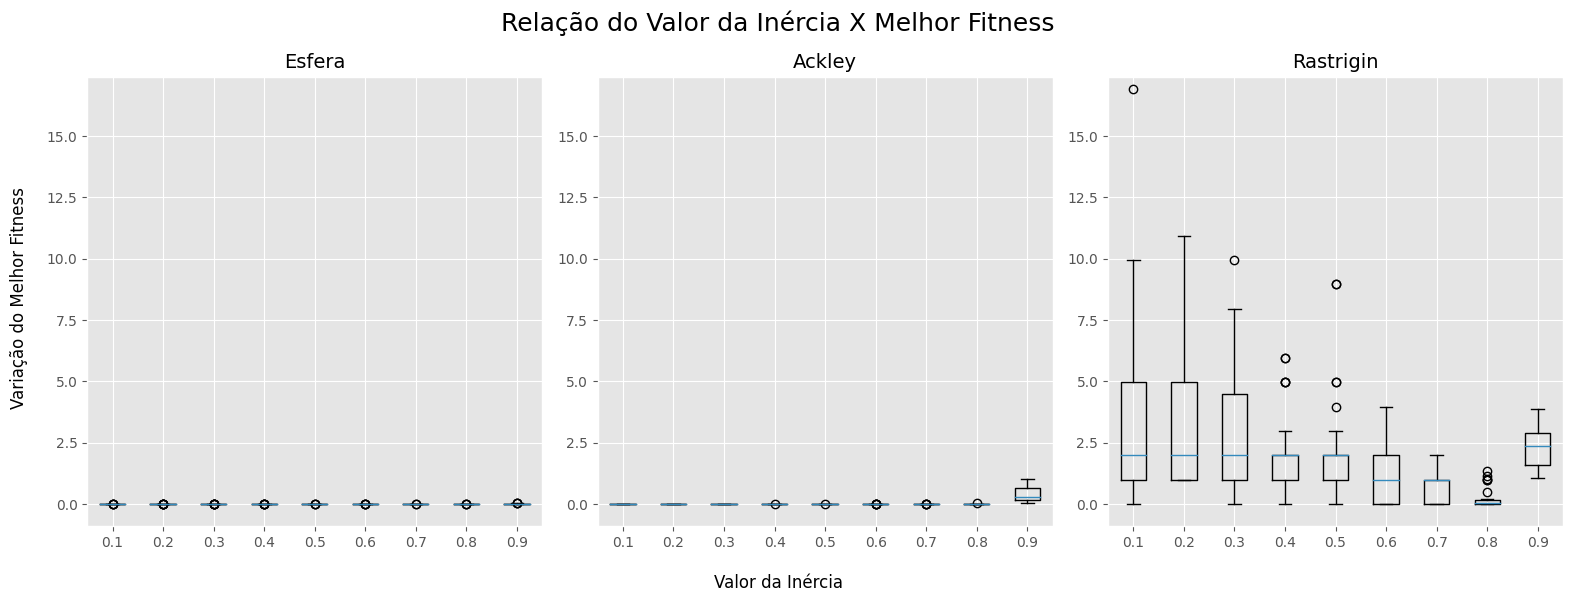

In [ ]:
data_2 = [sphere_ex2, ackley_ex2, rastrigin_ex2]
suptitle = 'Relação do Valor da Inércia X Melhor Fitness'
xlabel = 'Valor da Inércia'
xtick_labels = [round(label, 1) for label in inertia_range]

plot_graphics(data_2, titles, xtick_labels, xlabel, suptitle)

#### Na função da Esfera, a mudança no peso de inércia não teve grande impacto no melhor fitness, visto que essa não é uma função complexa de conversão.

#### Já na função Ackley, pode-se observar que o peso de inércia máximo teve um impacto negativo no melhor fitness, devido a um tamanho menor do passo da partícula, o que provavelmente a estagnou em um mínimo local, causando uma convergência mais lenta.

#### Por fim, na função Rastrigin, foi observado um impacto bastante significativo ao alterar o peso de inércia. Valores mínimos tiveram uma variação maior nos melhores fitness, com outliers, mesmo que tenham conseguido chegar no mínimo global. Valores médios tiveram uma melhor estabilidade no intervalo de melhor fitness, sendo o 0.8 o melhor peso de inércia observado. Da mesma forma que o Ackley, o valor máximo de inércia impactou negativamente, aumentando a distribuição dos melhores fitness e não obtendo a solução ótima.

### **3.** Variar topologia entre as opções: global e local com 2 vizinhos

In [ ]:
sphere_ex3 = []
rastrigin_ex3 = []
ackley_ex3 = []

for const in [False, True]:
  sphere_part = []
  rastrigin_part = []
  ackley_part = []

  for i in range(30):
      sphere_pso = PSO(sphere, sphere_bounds, local_topology=const)
      sphere_part.append(sphere_pso.results)

      rastrigin_pso = PSO(rastrigin, rastrigin_bounds, local_topology=const)
      rastrigin_part.append(rastrigin_pso.results)

      ackley_pso = PSO(ackley, ackley_bounds, local_topology=const)
      ackley_part.append(ackley_pso.results)

  sphere_ex3.append(sphere_part)
  rastrigin_ex3.append(rastrigin_part)
  ackley_ex3.append(ackley_part)

In [ ]:
sphere_results3 = median_min_max_by_exec(sphere_ex3)
rastrigin_results3 = median_min_max_by_exec(rastrigin_ex3)
ackley_results3 = median_min_max_by_exec(ackley_ex3)

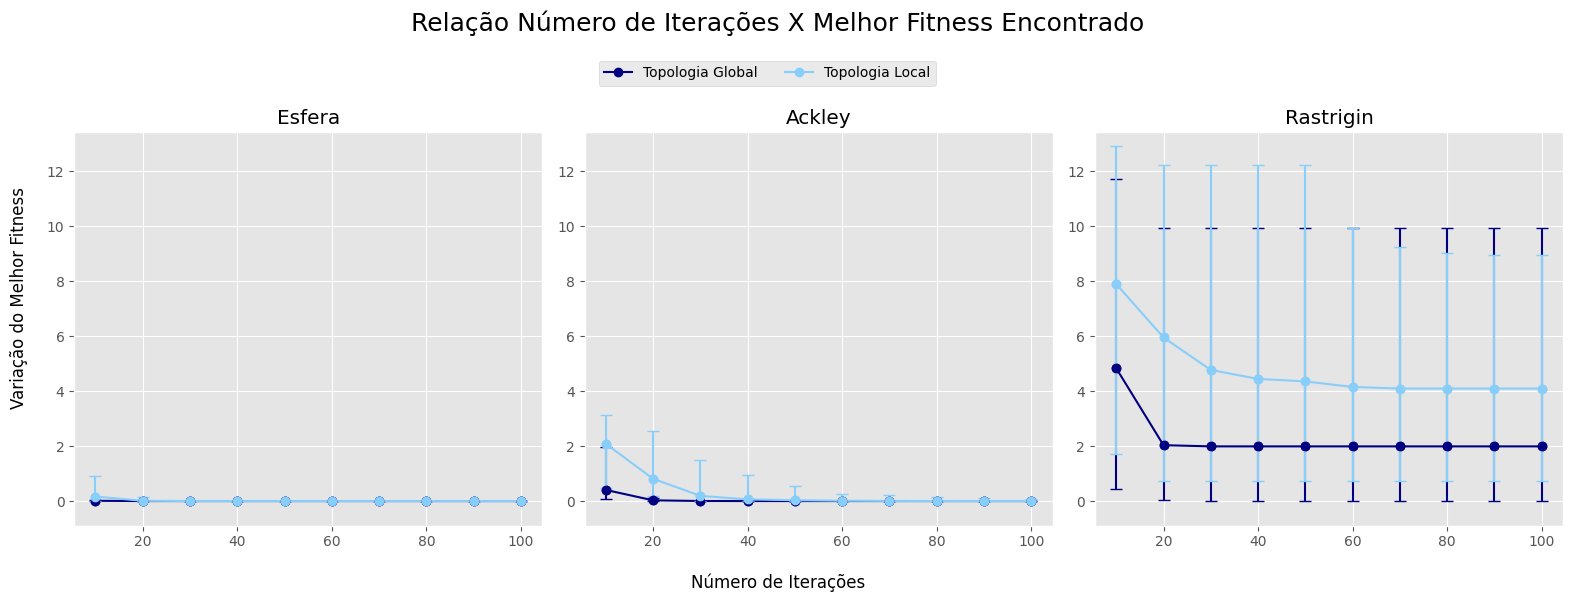

In [ ]:
data_3 = [sphere_results3, ackley_results3, rastrigin_results3]
suptitle = 'Relação Número de Iterações X Melhor Fitness Encontrado\n\n'
xlabel = 'Número de Iterações'
label = ['Topologia Global', 'Topologia Local']
plot_graphic_2(data_3, titles, suptitle, xlabel, label)

#### Na função esfera, a mudança entre o tipo de Topologia não afetou significativamente a convergência dos valores entre as iterações. Pode-se observar que no início há uma leve divergência, mas logo é convergida.

#### Na função Ackley, o resultado foi semelhante à esfera, no entanto, a convergência não foi rápida com a Topologia Local, além de que, sua variação se manteve alta durante todas as iterações, o que pode ser explicado pelos diversos mínimos locais que a função possui.

#### No entanto, na função Rastrigin, pode-se notar que a Topologia Local foi pior do que a global em todas as iterações, mantendo sua distribuição dos dados sempre maior do que a global. Isso ocorre devido à complexidade da função, com diversos mínimos locais, de modo a influenciar as partículas vizinhas a convergirem a essas soluções sub-ótimas.

### **4.** Variar a fórmula de atualização da velocidade entre as opções: tradicional e com fator de restrição

In [ ]:
c1 = c2 = 2.1
k = 2.0 / np.abs(2 - (c1 + c2) - math.sqrt((c1 + c2)**2 - 4 * (c1 + c2)))
print(k)

0.641742430504416


In [ ]:
sphere_ex4 = []
rastrigin_ex4 = []
ackley_ex4 = []

for const in [False, True]:
  sphere_part = []
  rastrigin_part = []
  ackley_part = []

  for i in range(30):
      sphere_pso = PSO(sphere, sphere_bounds, const_factor=const)
      sphere_part.append(sphere_pso.results)

      rastrigin_pso = PSO(rastrigin, rastrigin_bounds, const_factor=const)
      rastrigin_part.append(rastrigin_pso.results)

      ackley_pso = PSO(ackley, ackley_bounds, const_factor=const)
      ackley_part.append(ackley_pso.results)

  sphere_ex4.append(sphere_part)
  rastrigin_ex4.append(rastrigin_part)
  ackley_ex4.append(ackley_part)

In [ ]:
sphere_results = median_min_max_by_exec(sphere_ex4)
rastrigin_results = median_min_max_by_exec(rastrigin_ex4)
ackley_results = median_min_max_by_exec(ackley_ex4)

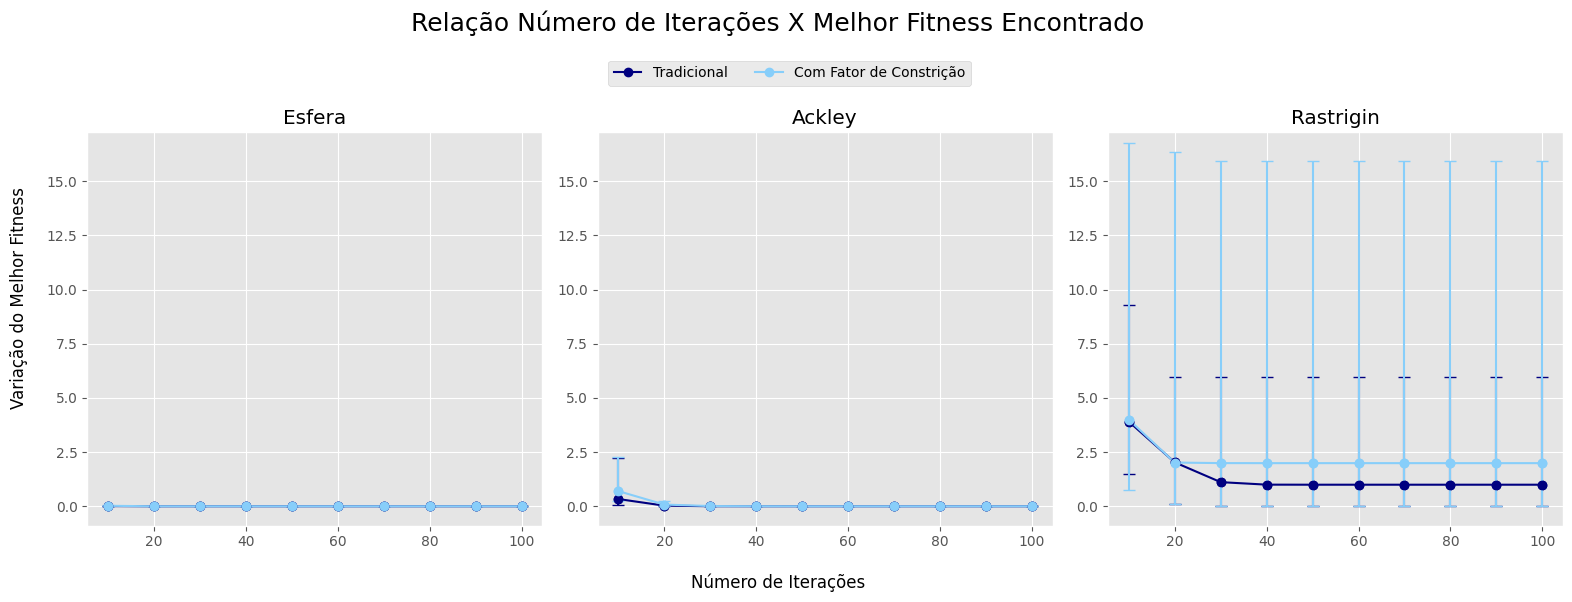

In [ ]:
data_4 = [sphere_results, ackley_results, rastrigin_results]
suptitle = 'Relação Número de Iterações X Melhor Fitness Encontrado\n\n'
xlabel = 'Número de Iterações'
label = ['Tradicional', 'Com Fator de Constrição']
plot_graphic_2(data_4, titles, suptitle, xlabel, label)

#### A Função Esfera não teve diferenças significativas com a mudança do fator de constrição ou no aumento das iterações.

#### Já na função Ackley, diferenças mínimas foram observadas até a iteração 20, porém a convergência foi encontrada em ambos os casos.

#### Por fim, na função Rastrigin, mesmo sua convergência ocorrendo a partir da iteração 30, a distribuição dos dados em ambos os tipos de fatores foi bastante alta, em que os dados sem Fator de Constrição obtiveram um impacto melhor, o que pode ser explicado pelo valor relativamente baixo obtido no cálculo do Fator, o que pode tornar a convergêcia mais lenta, visto que as partículas ficam limitas a mínimos locais, mesmo que o espaço de busca aumente. Isso ocorre devido à alta complexidade da função Rastrigin.

### **5.** Realizar teste estatístico

#### **1.** Variar o tamanho do enxame no intervalo [30 - 100] em passos de 10


In [ ]:
particles_range = list(range(30, 101, 10))

##### **ESFERA**

In [ ]:
sphere_results_population = [sphere_ex[i] for i in range(len(particles_range))]
perform_statistical_tests(sphere_results_population, particles_range, "Particles Range")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Label 1,Label 2,Tipo de Teste,p-value Wilcoxon,Resultado,p-value t-test
0,Particles Range: 30,Particles Range: 40,Wilcoxon test,6.899014e-02,Sem diferença significativa (Wilcoxon test),NaN
1,Particles Range: 30,Particles Range: 50,Wilcoxon test,1.947931e-04,Diferença significativa (Wilcoxon test),NaN
2,Particles Range: 30,Particles Range: 60,Wilcoxon test,1.478706e-05,Diferença significativa (Wilcoxon test),NaN
3,Particles Range: 30,Particles Range: 70,Wilcoxon test,6.505728e-06,Diferença significativa (Wilcoxon test),NaN
4,Particles Range: 30,Particles Range: 80,Wilcoxon test,3.999807e-09,Diferença significativa (Wilcoxon test),NaN
5,Particles Range: 30,Particles Range: 90,Wilcoxon test,2.737666e-10,Diferença significativa (Wilcoxon test),NaN
6,Particles Range: 30,Particles Range: 100,Wilcoxon test,1.347620e-09,Diferença significativa (Wilcoxon test),NaN
7,Particles Range: 40,Particles Range: 50,Wilcoxon test,1.729890e-02,Diferença significativa (Wilcoxon test),NaN
8,Particles Range: 40,Particles Range: 60,Wilcoxon test,2.688840e-03,Diferença significativa (Wilcoxon test),NaN
9,Particles Range: 40,Particles Range: 70,Wilcoxon test,8.794537e-04,Diferença significativa (Wilcoxon test),NaN


##### **ACKLEY**

In [ ]:
ackley_results_population = [ackley_ex[i] for i in range(len(particles_range))]
perform_statistical_tests(ackley_results_population, particles_range, "Population Size")

,Label 1,Label 2,Tipo de Teste,p-value Wilcoxon,Resultado
0,Population Size: 30,Population Size: 40,Wilcoxon test,1.038887e-01,Sem diferença significativa (Wilcoxon test)
1,Population Size: 30,Population Size: 50,Wilcoxon test,9.266594e-03,Diferença significativa (Wilcoxon test)
2,Population Size: 30,Population Size: 60,Wilcoxon test,5.818810e-07,Diferença significativa (Wilcoxon test)
3,Population Size: 30,Population Size: 70,Wilcoxon test,7.385504e-08,Diferença significativa (Wilcoxon test)
4,Population Size: 30,Population Size: 80,Wilcoxon test,5.224846e-09,Diferença significativa (Wilcoxon test)
5,Population Size: 30,Population Size: 90,Wilcoxon test,6.236874e-09,Diferença significativa (Wilcoxon test)
6,Population Size: 30,Population Size: 100,Wilcoxon test,4.373305e-09,Diferença significativa (Wilcoxon test)
7,Population Size: 40,Population Size: 50,Wilcoxon test,2.739342e-01,Sem diferença significativa (Wilcoxon test)
8,Population Size: 40,Population Size: 60,Wilcoxon test,5.433591e-05,Diferença significativa (Wilcoxon test)
9,Population Size: 40,Population Size: 70,Wilcoxon test,2.776959e-06,Diferença significativa (Wilcoxon test)


##### **RATRIGIN**

In [ ]:
rastrigin_results_population = [rastrigin_ex[i] for i in range(len(particles_range))]
perform_statistical_tests(rastrigin_results_population, particles_range, "Population Size")

,Label 1,Label 2,Tipo de Teste,p-value Wilcoxon,Resultado
0,Population Size: 30,Population Size: 40,Wilcoxon test,0.139289,Sem diferença significativa (Wilcoxon test)
1,Population Size: 30,Population Size: 50,Wilcoxon test,0.183321,Sem diferença significativa (Wilcoxon test)
2,Population Size: 30,Population Size: 60,Wilcoxon test,0.073628,Sem diferença significativa (Wilcoxon test)
3,Population Size: 30,Population Size: 70,Wilcoxon test,0.077272,Sem diferença significativa (Wilcoxon test)
4,Population Size: 30,Population Size: 80,Wilcoxon test,0.017299,Diferença significativa (Wilcoxon test)
5,Population Size: 30,Population Size: 90,Wilcoxon test,0.006669,Diferença significativa (Wilcoxon test)
6,Population Size: 30,Population Size: 100,Wilcoxon test,0.000749,Diferença significativa (Wilcoxon test)
7,Population Size: 40,Population Size: 50,Wilcoxon test,0.437641,Sem diferença significativa (Wilcoxon test)
8,Population Size: 40,Population Size: 60,Wilcoxon test,0.941072,Sem diferença significativa (Wilcoxon test)
9,Population Size: 40,Population Size: 70,Wilcoxon test,0.830255,Sem diferença significativa (Wilcoxon test)


#### **2.** Variar o valor de inércia no intervalo [0,1 - 0,9] em passos de 0,1

In [ ]:
inertia_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

##### **ESFERA**

In [ ]:
sphere_results_crossover = [sphere_ex2[i] for i in range(len(inertia_range))]
perform_statistical_tests(sphere_results_crossover, inertia_range, "Inertia Rate")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Label 1,Label 2,Tipo de Teste,p-value t-test,Resultado,p-value Wilcoxon
0,Inertia Rate: 0.1,Inertia Rate: 0.2,t-test,0.170146,Sem diferença significativa (t-test),NaN
1,Inertia Rate: 0.1,Inertia Rate: 0.3,t-test,0.027579,Diferença significativa (t-test),NaN
2,Inertia Rate: 0.1,Inertia Rate: 0.4,t-test,0.084755,Sem diferença significativa (t-test),NaN
3,Inertia Rate: 0.1,Inertia Rate: 0.5,Wilcoxon test,NaN,Diferença significativa (Wilcoxon test),2.871949e-11
4,Inertia Rate: 0.1,Inertia Rate: 0.6,Wilcoxon test,NaN,Diferença significativa (Wilcoxon test),2.871949e-11
5,Inertia Rate: 0.1,Inertia Rate: 0.7,Wilcoxon test,NaN,Diferença significativa (Wilcoxon test),2.871949e-11
6,Inertia Rate: 0.1,Inertia Rate: 0.8,Wilcoxon test,NaN,Diferença significativa (Wilcoxon test),2.871949e-11
7,Inertia Rate: 0.1,Inertia Rate: 0.9,Wilcoxon test,NaN,Diferença significativa (Wilcoxon test),2.871949e-11
8,Inertia Rate: 0.2,Inertia Rate: 0.3,t-test,0.027579,Diferença significativa (t-test),NaN
9,Inertia Rate: 0.2,Inertia Rate: 0.4,t-test,0.084755,Sem diferença significativa (t-test),NaN


##### **RASTRIGIN**

In [ ]:
rastrigin_results_crossover = [rastrigin_ex2[i] for i in range(len(inertia_range))]
perform_statistical_tests(rastrigin_results_crossover, inertia_range, "Inertia Rate")

,Label 1,Label 2,Tipo de Teste,p-value Wilcoxon,Resultado
0,Inertia Rate: 0.1,Inertia Rate: 0.2,Wilcoxon test,8.360240e-01,Sem diferença significativa (Wilcoxon test)
1,Inertia Rate: 0.1,Inertia Rate: 0.3,Wilcoxon test,3.830550e-01,Sem diferença significativa (Wilcoxon test)
2,Inertia Rate: 0.1,Inertia Rate: 0.4,Wilcoxon test,5.942792e-02,Sem diferença significativa (Wilcoxon test)
3,Inertia Rate: 0.1,Inertia Rate: 0.5,Wilcoxon test,1.315516e-01,Sem diferença significativa (Wilcoxon test)
4,Inertia Rate: 0.1,Inertia Rate: 0.6,Wilcoxon test,8.135063e-03,Diferença significativa (Wilcoxon test)
5,Inertia Rate: 0.1,Inertia Rate: 0.7,Wilcoxon test,3.092809e-04,Diferença significativa (Wilcoxon test)
6,Inertia Rate: 0.1,Inertia Rate: 0.8,Wilcoxon test,1.930892e-08,Diferença significativa (Wilcoxon test)
7,Inertia Rate: 0.1,Inertia Rate: 0.9,Wilcoxon test,8.130053e-01,Sem diferença significativa (Wilcoxon test)
8,Inertia Rate: 0.2,Inertia Rate: 0.3,Wilcoxon test,4.642729e-01,Sem diferença significativa (Wilcoxon test)
9,Inertia Rate: 0.2,Inertia Rate: 0.4,Wilcoxon test,7.604148e-02,Sem diferença significativa (Wilcoxon test)


##### **ACKLEY**

In [ ]:
ackley_results_crossover = [ackley_ex2[i] for i in range(len(inertia_range))]
perform_statistical_tests(ackley_results_crossover, inertia_range, "Inertia Rate")

,Label 1,Label 2,Tipo de Teste,p-value Wilcoxon,Resultado
0,Inertia Rate: 0.1,Inertia Rate: 0.2,Wilcoxon test,1.000000e+00,Sem diferença significativa (Wilcoxon test)
1,Inertia Rate: 0.1,Inertia Rate: 0.3,Wilcoxon test,2.675027e-01,Sem diferença significativa (Wilcoxon test)
2,Inertia Rate: 0.1,Inertia Rate: 0.4,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
3,Inertia Rate: 0.1,Inertia Rate: 0.5,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
4,Inertia Rate: 0.1,Inertia Rate: 0.6,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
5,Inertia Rate: 0.1,Inertia Rate: 0.7,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
6,Inertia Rate: 0.1,Inertia Rate: 0.8,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
7,Inertia Rate: 0.1,Inertia Rate: 0.9,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
8,Inertia Rate: 0.2,Inertia Rate: 0.3,Wilcoxon test,2.675027e-01,Sem diferença significativa (Wilcoxon test)
9,Inertia Rate: 0.2,Inertia Rate: 0.4,Wilcoxon test,2.871949e-11,Diferença significativa (Wilcoxon test)
